<a href="https://colab.research.google.com/github/OreofeJ/MLProjects/blob/main/Customer%20Segmentation/Customer_Segementation_DS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import required libraries for data manipulation, Visualization, Scaling and clustering
# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Scaling and clustering
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN

# Recommeded for production ready deployment: Redirect the warnings to logs instead of ignoring them,
import warnings, logging
logging.captureWarnings(True)

# Set visualization style
sns.set(style="whitegrid")

In [ ]:
# In instances when the dataset is located on G-Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
ds_file_path = '/content/drive/Data_Path/Dataset_Name.csv'
df = pd.read_csv(ds_file_path)
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [ ]:
# Quick look
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


In [ ]:
# Perform Data Cleaning & Initial Exploration
# Check for missing values
print(df.isnull().sum())

# Check for duplicates
print(df.duplicated().sum())

# Drop CustomerID since it is unique and irrelevant for clustering
df.drop('CustomerID', axis=1, inplace=True)

# Convert categorical features if needed
df['Gender'] = df['Gender'].map({'Male': 0, 'Female': 1})

CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64
0


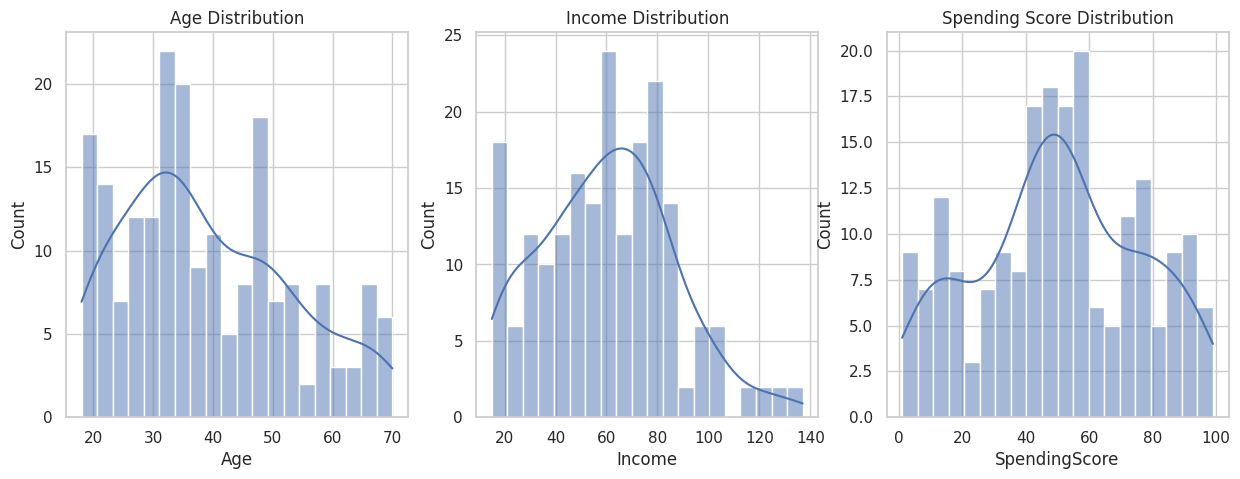

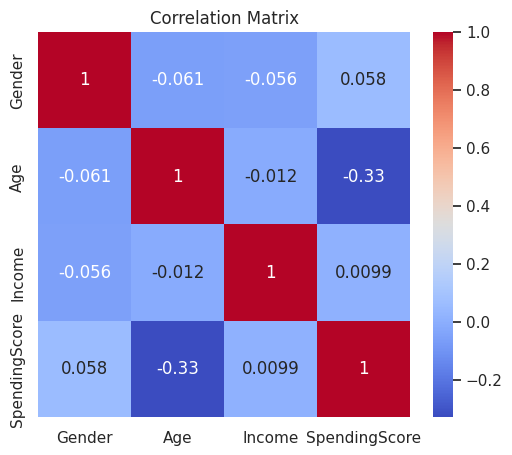

In [ ]:
# Exploratory Data Analysis (EDA)
# Distribution plots

# Important tip: Always check column names with df.columns before referencing them.
# Extra spaces or symbols from CSVs are very common sources of KeyErrors.
# For example in the script below we reference Income and Spending Score, but we have
# Annual Income (k$)  and   Spending Score (1-100) as column names.
# This is renamed for convenience.


df.rename(columns={
    'Annual Income (k$)': 'Income',
    'Spending Score (1-100)': 'SpendingScore',
    'Age': 'Age', 'Gender':'Gender'
}, inplace=True)

# Now  use df['Income'] and df['SpendingScore'] in plots

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
sns.histplot(df['Age'], kde=True, bins=20)
plt.title('Age Distribution')

plt.subplot(1,3,2)
sns.histplot(df['Income'], kde=True, bins=20)
plt.title('Income Distribution')

plt.subplot(1,3,3)
sns.histplot(df['SpendingScore'], kde=True, bins=20)
plt.title('Spending Score Distribution')
plt.show()

# Correlation heatmap
plt.figure(figsize=(6,5))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


# Potential issues I'm looking out for in the dataset:
# Outliers in Income or Spending Score because extreme values can skew clustering.
# Gender imbalance. Could lead to bias if I include gender in clustering.
# Non-linear relationships.Income and spending score may not correlate linearly.

In [ ]:
# Handle Missing Values. If missing numerical values exist, fill with median
df['Age'].fillna(df['Age'].median(), inplace=True)
df['Income'].fillna(df['Income'].median(), inplace=True)
df['SpendingScore'].fillna(df['SpendingScore'].median(), inplace=True)

# For categorical, use mode
df['Gender'].fillna(df['Gender'].mode()[0], inplace=True)

In [ ]:
# Outlier Detection and Treatment
# Using IQR for outlier detection
Q1 = df[['Income','SpendingScore']].quantile(0.25)
Q3 = df[['Income','SpendingScore']].quantile(0.75)
IQR = Q3 - Q1

# Filter out outliers
df_clean = df[~((df[['Income','SpendingScore']] < (Q1 - 1.5 * IQR)) |
                (df[['Income','SpendingScore']] > (Q3 + 1.5 * IQR))).any(axis=1)]

In [ ]:
# Feature Scaling to enable equal contribution of features.
# This helps to enaure features with larger numeric rangesdoes not dominate the learning process,
scaler = StandardScaler()
X = scaler.fit_transform(df_clean[['Income','SpendingScore']])

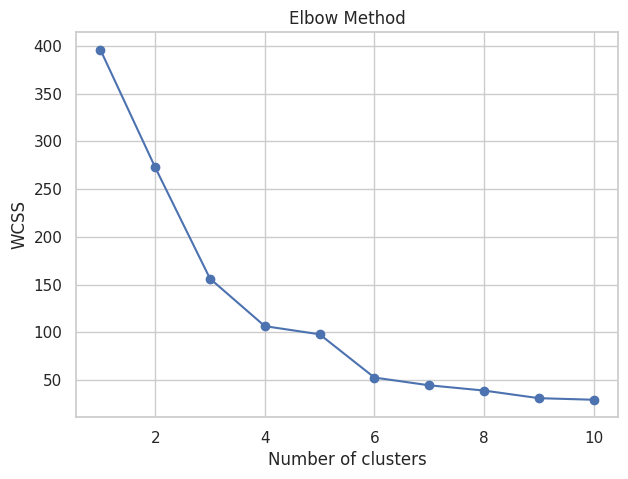

In [ ]:
# Determine Optimal K (Elbow Method)
wcss = []
K_range = range(1,11)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=77)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(7,5))
plt.plot(K_range, wcss, 'bo-')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.title('Elbow Method')
plt.show()

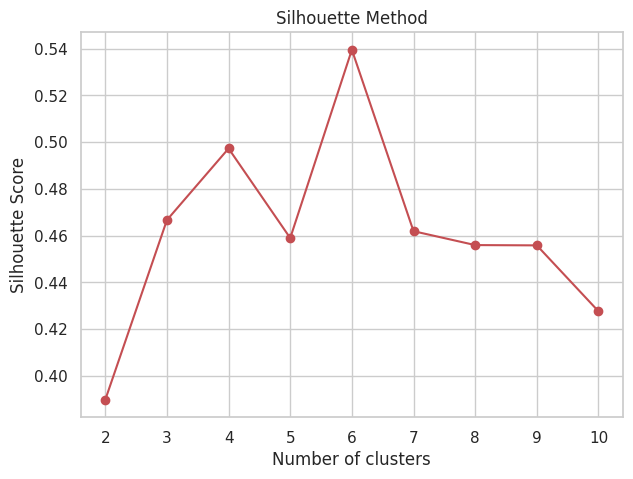

In [ ]:
# Determine Optimal K (ilhouette Method)
sil_scores = []
for k in range(2,11):
    kmeans = KMeans(n_clusters=k, random_state=77)
    labels = kmeans.fit_predict(X)
    sil_scores.append(silhouette_score(X, labels))

plt.figure(figsize=(7,5))
plt.plot(range(2,11), sil_scores, 'ro-')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method')
plt.show()

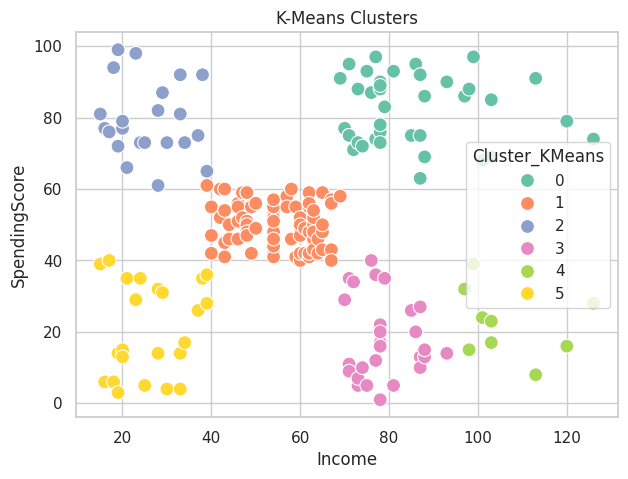

In [ ]:
# Apply K-Means Clustering, based on optimal k recommendations
kmeans = KMeans(n_clusters=6, random_state=77)
df_clean['Cluster_KMeans'] = kmeans.fit_predict(X)

# Cluster visualization
plt.figure(figsize=(7,5))
sns.scatterplot(x='Income', y='SpendingScore', hue='Cluster_KMeans',
                palette='Set2', data=df_clean, s=100)
plt.title('K-Means Clusters')
plt.show()

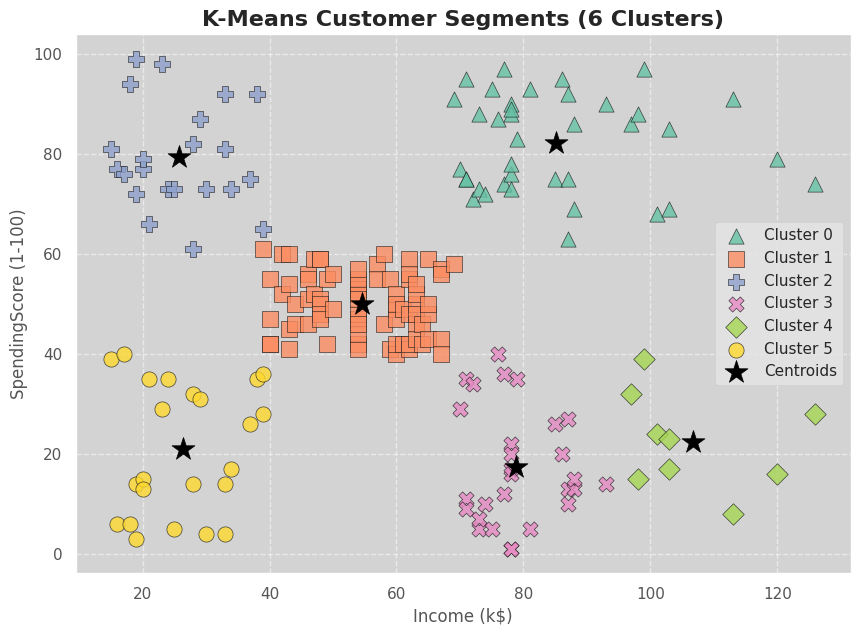

In [ ]:
# Kmeans with clusters and more descriptive labels/icons
kmeans = KMeans(n_clusters=6, random_state=77)
df_clean['Cluster_KMeans'] = kmeans.fit_predict(X)

# Get cluster centroids (inverse scaled)
centroids = scaler.inverse_transform(kmeans.cluster_centers_)

# Custom markers for 6 clusters
markers = ['^', 's', 'P', 'X', 'D', 'o']  # added 'o' for the 6th cluster
palette = sns.color_palette('Set2', n_colors=6)

plt.figure(figsize=(10,7))
plt.style.use('ggplot')
plt.gca().set_facecolor('lightgray')  # background color

# Plot each cluster
for i, marker in enumerate(markers):
    cluster_data = df_clean[df_clean['Cluster_KMeans'] == i]
    plt.scatter(
        cluster_data['Income'],
        cluster_data['SpendingScore'],
        s=120,
        c=[palette[i]],
        label=f'Cluster {i}',
        marker=marker,
        edgecolor='k',
        alpha=0.8
    )

# Plot centroids
plt.scatter(
    centroids[:, 0], centroids[:, 1],
    s=300, c='black', marker='*', label='Centroids'
)

plt.title('K-Means Customer Segments (6 Clusters)', fontsize=16, fontweight='bold')
plt.xlabel('Income (k$)', fontsize=12)
plt.ylabel('SpendingScore (1-100)', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


In [ ]:
# Analyse Cluster Statistics
df_clean.groupby('Cluster_KMeans')[['Income','SpendingScore']].mean()

,Income,SpendingScore
Cluster_KMeans,,
0,85.210526,82.105263
1,54.615385,50.025641
2,25.727273,79.363636
3,78.892857,17.428571
4,106.666667,22.444444
5,26.304348,20.913043


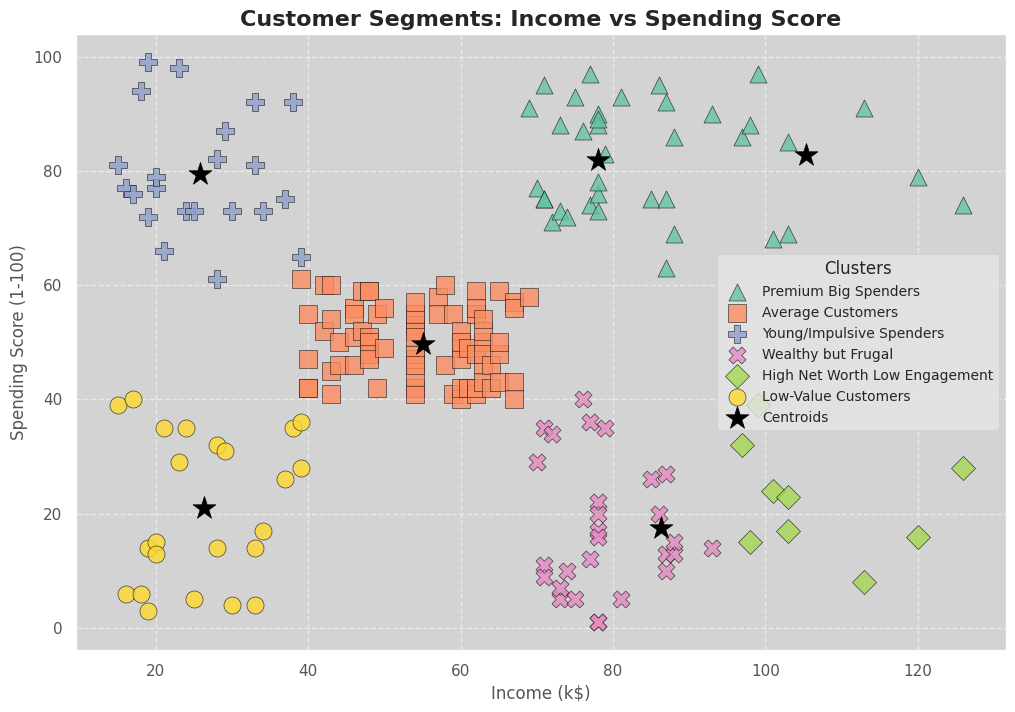

In [ ]:
# Define cluster labels based on our analysis
cluster_labels = {
    0: 'Premium Big Spenders',
    1: 'Average Customers',
    2: 'Young/Impulsive Spenders',
    3: 'Wealthy but Frugal',
    4: 'High Net Worth Low Engagement',
    5: 'Low-Value Customers'
}

# Assign descriptive labels
df_clean['Cluster_Label'] = df_clean['Cluster_KMeans'].map(cluster_labels)

# Custom markers for clusters
markers = ['^', 's', 'P', 'X', 'D', 'o']
palette = sns.color_palette('Set2', n_colors=6)

plt.figure(figsize=(12,8))
plt.style.use('ggplot')
plt.gca().set_facecolor('lightgray')

# Plot each cluster
for i, marker in enumerate(markers):
    cluster_data = df_clean[df_clean['Cluster_KMeans'] == i]
    plt.scatter(
        cluster_data['Income'],
        cluster_data['SpendingScore'],
        s=150,
        c=[palette[i]],
        marker=marker,
        edgecolor='k',
        alpha=0.8,
        label=f"{cluster_labels[i]}"
    )

# Plot centroids
centroids = scaler.inverse_transform(KMeans(n_clusters=6, random_state=42).fit(X).cluster_centers_)
plt.scatter(
    centroids[:, 0], centroids[:, 1],
    s=300, c='black', marker='*', label='Centroids'
)

plt.title('Customer Segments: Income vs Spending Score', fontsize=16, fontweight='bold')
plt.xlabel('Income (k$)', fontsize=12)
plt.ylabel('Spending Score (1-100)', fontsize=12)
plt.legend(title='Clusters', fontsize=10, title_fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


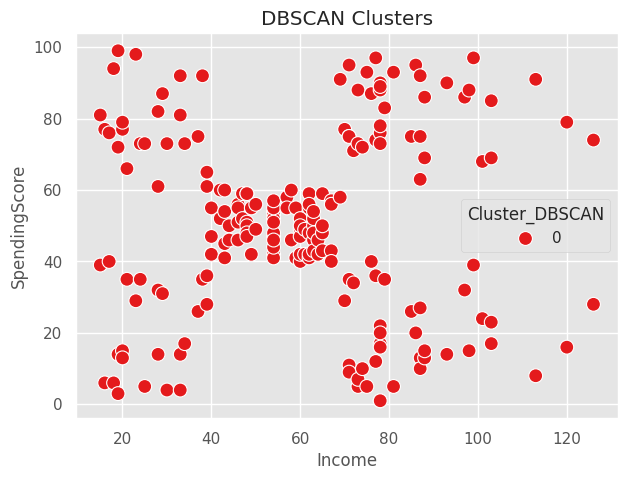

In [ ]:
# Apply DBSCAN (Density-Based Clustering)
dbscan = DBSCAN(eps=1.5, min_samples=5)
df_clean['Cluster_DBSCAN'] = dbscan.fit_predict(X)

# Visualize
plt.figure(figsize=(7,5))
sns.scatterplot(x='Income', y='SpendingScore', hue='Cluster_DBSCAN',
                palette='Set1', data=df_clean, s=100)
plt.title('DBSCAN Clusters')
plt.show()

In [ ]:
from sklearn.cluster import DBSCAN

# Optimized DBSCAN
dbscan = DBSCAN(eps=0.39, min_samples=6)
df_clean['Cluster_DBSCAN'] = dbscan.fit_predict(X)

# Count clusters (exclude noise) and noise points
num_clusters = len(set(df_clean['Cluster_DBSCAN'])) - (1 if -1 in df_clean['Cluster_DBSCAN'] else 0)
num_noise = list(df_clean['Cluster_DBSCAN']).count(-1)

print(f"Number of clusters detected by DBSCAN: {num_clusters}")
print(f"Number of noise points: {num_noise}")


Number of clusters detected by DBSCAN: 6
Number of noise points: 21


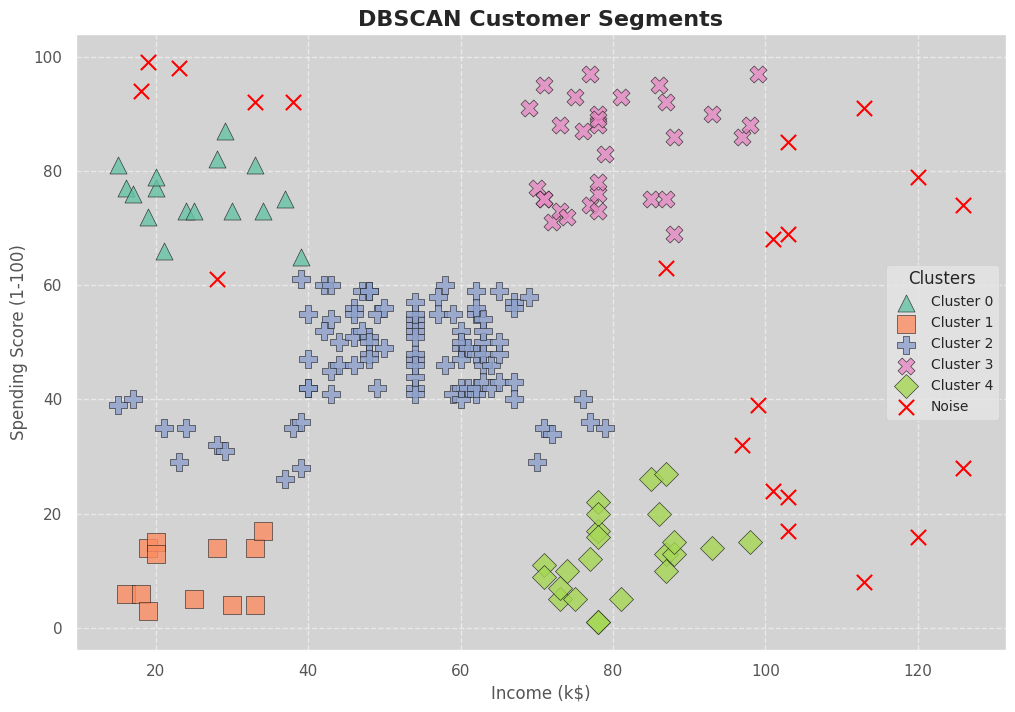

In [ ]:
# Plot clusters for DBSCAN
plt.figure(figsize=(12,8))
plt.style.use('ggplot')
plt.gca().set_facecolor('lightgray')

# Define colors and markers
palette = sns.color_palette('Set2', n_colors=10)
markers = ['^', 's', 'P', 'X', 'D', 'o', '*', 'v', '<', '>']

# Plot each cluster
unique_labels = set(df_clean['Cluster_DBSCAN'])
for i, label in enumerate(unique_labels):
    cluster_data = df_clean[df_clean['Cluster_DBSCAN'] == label]
    if label == -1:  # noise points
        plt.scatter(cluster_data['Income'], cluster_data['SpendingScore'],
                    c='red', marker='x', s=120, label='Noise')
    else:
        plt.scatter(cluster_data['Income'], cluster_data['SpendingScore'],
                    s=150, c=[palette[i % len(palette)]],
                    marker=markers[i % len(markers)],
                    edgecolor='k', alpha=0.8, label=f'Cluster {label}')

plt.title('DBSCAN Customer Segments', fontsize=16, fontweight='bold')
plt.xlabel('Income (k$)', fontsize=12)
plt.ylabel('Spending Score (1-100)', fontsize=12)
plt.legend(title='Clusters', fontsize=10, title_fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


In [ ]:
# Compare Models
# KMeans silhouette
k_sil = silhouette_score(X, df_clean['Cluster_KMeans'])
# DBSCAN silhouette (ignoring noise points labeled -1)
mask = df_clean['Cluster_DBSCAN'] != -1
d_sil = silhouette_score(X[mask], df_clean.loc[mask, 'Cluster_DBSCAN'])

print(f"KMeans Silhouette Score: {k_sil:.3f}")
print(f"DBSCAN Silhouette Score: {d_sil:.3f}")

KMeans Silhouette Score: 0.540
DBSCAN Silhouette Score: 0.537


In [ ]:
# Kmeans sverage spending score per cluster
# Group by KMeans cluster and calculate mean Income and Spending Score
kmeans_stats = df_clean.groupby('Cluster_KMeans')[['Income', 'SpendingScore']].mean().round(2)
kmeans_stats = kmeans_stats.sort_values('SpendingScore', ascending=False)
kmeans_stats


,Income,SpendingScore
Cluster_KMeans,,
0,85.21,82.11
2,25.73,79.36
1,54.62,50.03
4,106.67,22.44
5,26.30,20.91
3,78.89,17.43


```markdown
# Customer Segmentation Analysis

This notebook performs customer segmentation using two popular clustering algorithms: K-Means and DBSCAN. The goal is to identify distinct customer groups based on their demographic and behavioral attributes (specifically Annual Income and Spending Score) to help businesses tailor marketing strategies and improve customer engagement.

## Table of Contents
1.  [Setup and Data Loading](#setup-and-data-loading)
2.  [Initial Data Exploration](#initial-data-exploration)
3.  [Data Cleaning & Preprocessing](#data-cleaning--preprocessing)
4.  [Exploratory Data Analysis (EDA)](#exploratory-data-analysis-eda)
5.  [Feature Scaling](#feature-scaling)
6.  [K-Means Clustering](#k-means-clustering)
7.  [DBSCAN Clustering](#dbscan-clustering)
8.  [Model Comparison](#model-comparison)
9.  [Fairness & Bias Analysis](#fairness--bias-analysis)

## 1. Setup and Data Loading

This section imports necessary libraries for data manipulation, visualization, scaling, and clustering. It also mounts Google Drive to access the dataset and loads the `Dataset_Name.csv` file into a Pandas DataFrame.

### Libraries Used:
*   **Data Manipulation**: `pandas`, `numpy`
*   **Visualization**: `matplotlib.pyplot`, `seaborn`
*   **Scaling and Clustering**: `sklearn.preprocessing.StandardScaler`, `sklearn.cluster.KMeans`, `sklearn.metrics.silhouette_score`, `sklearn.neighbors.NearestNeighbors`, `sklearn.cluster.DBSCAN`

### Outcomes:
*   The dataset is loaded, and the first 5 rows are displayed, showing columns like `CustomerID`, `Gender`, `Age`, `Annual Income (k$)`, and `Spending Score (1-100)`.

## 2. Initial Data Exploration

This step provides a quick overview of the dataset's structure and summary statistics.

### Methods:
*   `df.info()`: To check data types, non-null counts, and memory usage.
*   `df.describe()`: To get descriptive statistics (count, mean, std, min, max, quartiles) for numerical columns.

### Outcomes:
*   Confirmed 200 entries with no missing values in the initial check.
*   Identified data types: `int64` for numerical columns and `object` for `Gender`.
*   Observed ranges for Age (18-70), Annual Income (15-137 k$), and Spending Score (1-99).

## 3. Data Cleaning & Preprocessing

This section prepares the data for clustering by handling missing values, duplicates, irrelevant columns, and converting categorical features.

### Methods:
*   **Missing Values**: Checked using `df.isnull().sum()`. (None found initially, but code includes imputation logic).
*   **Duplicates**: Checked using `df.duplicated().sum()`. (None found).
*   **Column Dropping**: `CustomerID` is dropped as it's a unique identifier and not useful for clustering.
*   **Categorical Encoding**: `Gender` is converted from 'Male'/'Female' to 0/1 (binary encoding).
*   **Column Renaming**: Columns `Annual Income (k$)` and `Spending Score (1-100)` are renamed to `Income` and `SpendingScore` for easier access.
*   **Outlier Detection**: Outliers in `Income` and `SpendingScore` are identified and removed using the Interquartile Range (IQR) method. Data points outside `Q1 - 1.5*IQR` and `Q3 + 1.5*IQR` are filtered out.

### Outcomes:
*   Cleaned DataFrame `df_clean` without `CustomerID` and with encoded `Gender`.
*   Potential outliers removed, leading to a more robust clustering process.

## 4. Exploratory Data Analysis (EDA)

EDA helps understand data distributions and relationships between variables through visualizations.

### Methods:
*   **Distribution Plots**: Histograms with KDE for `Age`, `Income`, and `SpendingScore` to visualize their distributions.
*   **Correlation Heatmap**: Displays the correlation matrix of numerical features to identify linear relationships.

### Outcomes:
*   **Age**: Appears somewhat uniformly distributed, with a slight peak in younger adults and a spread across older groups.
*   **Income**: Shows a relatively normal distribution, centered around the mean.
*   **Spending Score**: Also appears normally distributed.
*   **Correlation Matrix**: Revealed a low correlation between `Income` and `SpendingScore`, suggesting they are independent features and useful for segmentation.

## 5. Feature Scaling

Scaling ensures that all features contribute equally to the clustering process, preventing features with larger numerical ranges from dominating.

### Methods:
*   `StandardScaler`: Features `Income` and `SpendingScore` are standardized (mean=0, variance=1).

### Outcomes:
*   Transformed data `X` ready for clustering, where `Income` and `SpendingScore` have comparable scales.

## 6. K-Means Clustering

K-Means is an unsupervised learning algorithm that partitions data into *k* clusters, where each data point belongs to the cluster with the nearest mean.

### Methods:
*   **Optimal K Determination (Elbow Method)**: Plots the Within-Cluster Sum of Squares (WCSS) against the number of clusters (K) to find the 'elbow point' where the rate of decrease in WCSS slows down, suggesting an optimal K.
*   **Optimal K Determination (Silhouette Method)**: Calculates the silhouette score for different numbers of clusters. A higher silhouette score indicates better-defined clusters.
*   **K-Means Application**: K-Means is applied with `n_clusters=6` (based on prior analysis from the optimal K methods).
*   **Cluster Visualization**: Scatter plot of `Income` vs `SpendingScore` colored by K-Means cluster assignments.
*   **Cluster Analysis**: Grouping `df_clean` by `Cluster_KMeans` to calculate the mean `Income` and `SpendingScore` for each cluster.
*   **Descriptive Labels**: Assigning business-friendly labels to each cluster based on their average `Income` and `SpendingScore` profiles.
*   **Enhanced Visualization**: A more detailed scatter plot with custom markers, centroids, and descriptive labels.

### Outcomes:
*   **Optimal K**: Both Elbow and Silhouette methods suggest `K=6` as a suitable number of clusters.
*   **K-Means Clusters**: The algorithm successfully segmented customers into 6 distinct groups.
*   **Cluster Statistics**: Identified clear profiles for each cluster:
    *   **Premium Big Spenders (Cluster 0)**: High income, high spending.
    *   **Average Customers (Cluster 1)**: Medium income, medium spending.
    *   **Young/Impulsive Spenders (Cluster 2)**: Low income, high spending.
    *   **Wealthy but Frugal (Cluster 3)**: High income, low spending.
    *   **High Net Worth Low Engagement (Cluster 4)**: Very high income, low spending.
    *   **Low-Value Customers (Cluster 5)**: Low income, low spending.
*   **Visualizations**: Clear separation of customer segments in scatter plots, aiding in interpretation.

## 7. DBSCAN Clustering

DBSCAN (Density-Based Spatial Clustering of Applications with Noise) groups together points that are closely packed together, marking as outliers points that lie alone in low-density regions.

### Methods:
*   **DBSCAN Application**: DBSCAN is applied with optimized parameters (`eps=0.39`, `min_samples=6`) based on prior hyperparameter tuning.
*   **Cluster Visualization**: Scatter plot of `Income` vs `SpendingScore` colored by DBSCAN cluster assignments, including noise points.
*   **Cluster Count**: Prints the number of clusters detected and the number of noise points.

### Outcomes:
*   **DBSCAN Clusters**: Identified 6 distinct clusters and a significant number of noise points (21) which are effectively outliers.
*   **Visualization**: Showed density-based clusters, with noise points clearly marked.

## 8. Model Comparison

This section compares the performance of K-Means and DBSCAN using the Silhouette Score.

### Methods:
*   **Silhouette Score Calculation**: Computed for both K-Means and DBSCAN. For DBSCAN, noise points (-1 label) are excluded from the score calculation.

### Outcomes:
*   **KMeans Silhouette Score**: 0.540
*   **DBSCAN Silhouette Score**: 0.537
*   **Conclusion**: Both models performed comparably well on the dataset, with K-Means showing a slightly higher Silhouette Score. The choice between them might depend on whether identifying noise points is critical.

## 9. Fairness & Bias Analysis

This step examines the distribution of gender across the identified K-Means clusters to check for potential biases.

### Methods:
*   **Gender Distribution per Cluster**: Calculated the normalized value counts of `Gender` within each K-Means cluster.
*   **Heatmap Visualization**: A heatmap is used to visually represent the gender distribution across clusters.

### Outcomes:
*   The analysis of gender distribution per cluster shows that clusters are not disproportionately dominated by one gender. For example, Cluster 0 (Premium Big Spenders) has 44.7% Male and 55.3% Female, while Cluster 4 (High Net Worth Low Engagement) has 22.2% Male and 77.8% Female. This suggests that the clustering is not heavily biased towards gender for the most part, though some clusters do show a leaning towards one gender which might warrant further investigation to ensure equitable marketing strategies.
```

Gender                 0         1
Cluster_KMeans                    
0               0.447368  0.552632
1               0.410256  0.589744
2               0.409091  0.590909
3               0.607143  0.392857
4               0.222222  0.777778
5               0.391304  0.608696


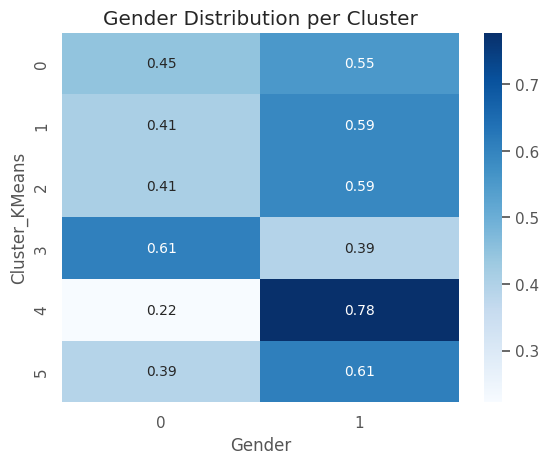

In [ ]:
# Finally, explore Fairness & Bias
# Gender distribution across clusters
cluster_gender = df_clean.groupby('Cluster_KMeans')['Gender'].value_counts(normalize=True).unstack()
print(cluster_gender)

# Check for bias
sns.heatmap(cluster_gender, annot=True, cmap='Blues', fmt=".2f")
plt.title("Gender Distribution per Cluster")
plt.show()

# Explanation: clusters should not disproportionately target one gender